# 1. Compressing Data via Dimensionality Reduction
- Similar to Feature selection, we use different techniques to reduce the number of features in a dataset
- The difference is that instead of maintaining the original features, we use feature extraction to transform or project the data onto a new feature space
- In practice, feature extraction improves storage space, the computational efficiency and can also positively affect the predictive performance by reducing the curse of dimensionality
## Basic imports

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, '../..')
from imports.methods import plot_decision_regions

# 2. Unsupervised dimensionality reduction via principal component analysis
- The main idea is pretty simple, we find the line that fits the training data in the best possible way in all feature dimensions (by "fits" we mean that the summed squared distance from all of the training samples to the line we are trying to fit is minimal), which becomes our PC1 (first principal component) and all other PCs are the perpendicular to PC1 lines in the remaining (n-1) feature dimensions
- Detailed explanations: https://www.youtube.com/watch?v=FgakZw6K1QQ (StatQuest: Principal Component Analysis (PCA), Step-by-Step by StatQuest - works July 2020)
## 1. Extracting the principal components step-by-step
### 1. Loading the Wine dataset

In [21]:
df_wine = pd.read_csv('data/wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


### 2. Splitting the data into 70% training and 30% test subsets

In [22]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, 
                     stratify=y,
                     random_state=0)

### 3. Standardizing the data

In [23]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

---

**Note from the original book's code notebook**

Accidentally, I wrote `X_test_std = sc.fit_transform(X_test)` instead of `X_test_std = sc.transform(X_test)`. In this case, it wouldn't make a big difference since the mean and standard deviation of the test set should be (quite) similar to the training set. However, as remember from Chapter 3, the correct way is to re-use parameters from the training set if we are doing any kind of transformation -- the test set should basically stand for "new, unseen" data.

My initial typo reflects a common mistake is that some people are *not* re-using these parameters from the model training/building and standardize the new data "from scratch." Here's simple example to explain why this is a problem.

Let's assume we have a simple training set consisting of 3 examples with 1 feature (let's call this feature "length"):

- train_1: 10 cm -> class_2
- train_2: 20 cm -> class_2
- train_3: 30 cm -> class_1

mean: 20, std.: 8.2

After standardization, the transformed feature values are

- train_std_1: -1.21 -> class_2
- train_std_2: 0 -> class_2
- train_std_3: 1.21 -> class_1

Next, let's assume our model has learned to classify examples with a standardized length value < 0.6 as class_2 (class_1 otherwise). So far so good. Now, let's say we have 3 unlabeled data points that we want to classify:

- new_4: 5 cm -> class ?
- new_5: 6 cm -> class ?
- new_6: 7 cm -> class ?

If we look at the "unstandardized "length" values in our training datast, it is intuitive to say that all of these examples are likely belonging to class_2. However, if we standardize these by re-computing standard deviation and and mean you would get similar values as before in the training set and your classifier would (probably incorrectly) classify examples 4 and 5 as class 2.

- new_std_4: -1.21 -> class 2
- new_std_5: 0 -> class 2
- new_std_6: 1.21 -> class 1

However, if we use the parameters from your "training set standardization," we'd get the values:

- example5: -18.37 -> class 2
- example6: -17.15 -> class 2
- example7: -15.92 -> class 2

The values 5 cm, 6 cm, and 7 cm are much lower than anything we have seen in the training set previously. Thus, it only makes sense that the standardized features of the "new examples" are much lower than every standardized feature in the training set.

---

## 2. Obtaining the covariance matrix and performing Eigendecomposition of it

In [24]:
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n%s' % eigen_vals)


Eigenvalues 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


## 3. Total and explained variance
- Since we want to reduce the dimensionality of our dataset by compressing it onto a new feature subspace, we only select the subset of the eigenvectors (principal components) that contains most of the information (variance) // book quote
- Variance explained ratios show the relative importance of each of the principal components

In [25]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

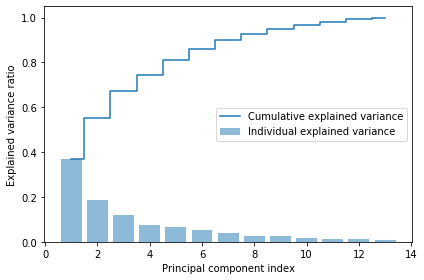

In [26]:
plt.bar(range(1, 14), var_exp, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

- The important difference to the feature importance values that we computed via random forests is that PCA is an unsupervised method, which means that we disregard the class membership information and only measure the spread of values along feature axis (in comparison to computing node impurities, which requires class membership information)

## 4. Feature transformation
### 1. Make a list of (eigenvalue, eigenvector) tuples

In [27]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

### 2. Sort the (eigenvalue, eigenvector) tuples from high to low

In [28]:
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

### 3. Horizontally stack the chosen number of the highest eigenvectors by eigenvalue to obtain the projection matrix
- We need to transform the eigenvectors into column vectors before stacking them horizontally
(`eigen_pairs[0][1][:, np.newaxis]` does that by adding a new dimension)


In [29]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


## 5. Transforming an example from the 13-dimensional dataset onto the PCA subspace

In [30]:
X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

## 6. Visualizing the transformed Wine training dataset

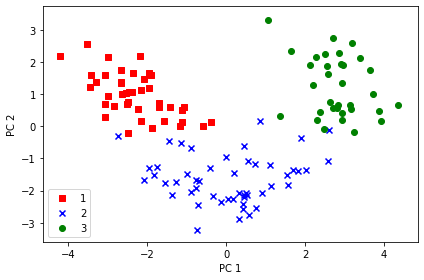

In [31]:
X_train_pca = X_train_std.dot(w)

colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

## 7. Training logistic regression classifier using the first 2 principal components
- PCA from sklearn.decomposition is the scikit-learn implementation of principal component analysis

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_pca, y_train)

### 1. Plotting the decision regions for training data

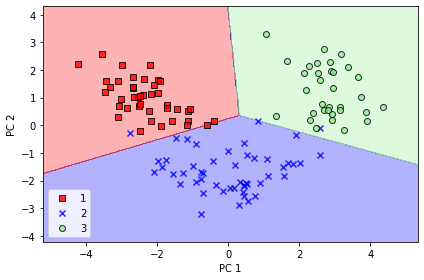

In [35]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

### 2. Plotting the decision regions for testing data

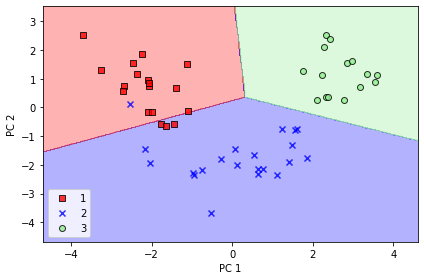

In [36]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

## 8. Getting explained variance ratios using scikit-learn

In [37]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

# 3. Supervised data compression via linear discriminant analysis
- The general concept behind LDA is very similar to PCA, but whereas PCA attempts to find the orthogonal component axes of maximum variance in a dataset, the goal in LDA is to find the feature subspace that optimizes class separability // book quote
- Detailed explanations: https://www.youtube.com/watch?v=azXCzI57Yfc (StatQuest: Linear Discriminant Analysis (LDA) clearly explained by StatQuest - works July 2020)

## 1. Computing the scatter matrices
### 1. Calculate the mean vectors for each class

In [38]:
np.set_printoptions(precision=4)

mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print('MV %s: %s\n' % (label, mean_vecs[label - 1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



### 2.1. Compute the within-class scatter matrix

In [39]:
d = 13 # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))  # scatter matrix for each class
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)  # make column vectors
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter                          # sum class scatter matrices

print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


### 2.2. Better: covariance matrix since classes are not equally distributed
- The assumption that we are making when we are computing the scatter matrices is that the class labels in the training dataset are uniformly distributed, which is not the case as can be seen below

In [40]:
print('Class label distribution: %s' 
      % np.bincount(y_train)[1:])

Class label distribution: [41 50 33]


- Thus, we want to scale the individual scatter matrices before we sum them up as scatter matrix
- When we divide the scatter matrices by the number of class-examples we can see that computing the scatter matrix is in fact the same as computing the covariance matrix - the covariance matrix is a normalized version of the scatter matrix // book quote

In [43]:
d = 13  # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
print('Scaled within-class scatter matrix: %sx%s' % (S_W.shape[0],
                                                     S_W.shape[1]))

Scaled within-class scatter matrix: 13x13


### 3. Compute the between-class scatter matrix

In [45]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13  # number of features
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # make column vector
    mean_overall = mean_overall.reshape(d, 1)  # make column vector
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


## 2. Selecting linear discriminants for the new feature subspace
### 1. Solve the generalized eigenvalue problem for the matrix $S_W^{-1}S_B$:

In [46]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

### 2. Sort eigenvectors in descending order of the eigenvalues

In [47]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in descending order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

349.6178089059939
172.76152218979388
3.7853134512521556e-14
2.117398448224407e-14
1.5164618894178885e-14
1.5164618894178885e-14
1.3579567140455979e-14
1.3579567140455979e-14
7.587760371654683e-15
5.906039984472233e-15
5.906039984472233e-15
2.256441978569674e-15
0.0


## 3. Discriminability of linear discriminants
- On the plot we can see how much of the class-discriminatory information is captured by the linear discriminants (eigenvectors)

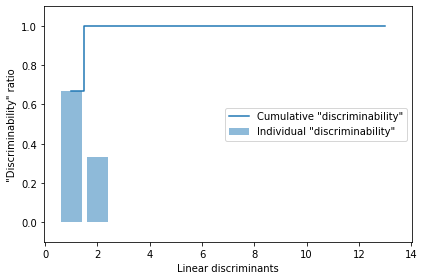

In [49]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, alpha=0.5, align='center',
        label='Individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid',
         label='Cumulative "discriminability"')
plt.ylabel('"Discriminability" ratio')
plt.xlabel('Linear discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### 1. Horizontally stack the chosen number of the highest eigenvectors by eigenvalue to obtain the transformation matrix

In [50]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


## 4. Projecting examples onto the new feature space

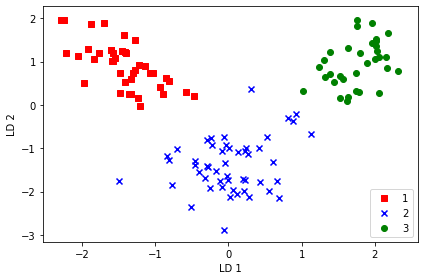

In [51]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0],
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=l, marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## 5. LDA via scikit-learn

In [53]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

### 1. Plotting the decision regions for training data

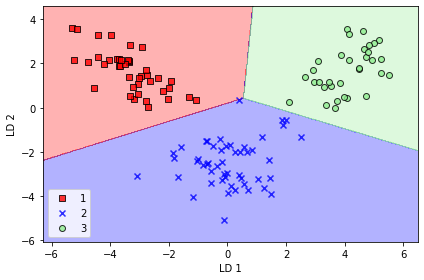

In [54]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

### 2. Plotting the decision regions for testing data

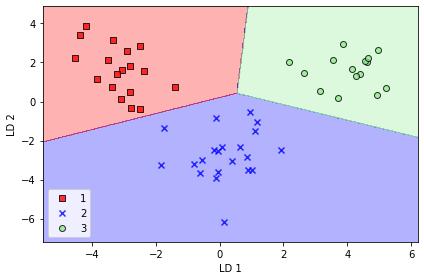

In [56]:
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

# 4. Using kernel principal component analysis for nonlinear mappings
## 1. Implementing a kernel principal component analysis in Python

In [57]:
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh
import numpy as np

from distutils.version import LooseVersion as Version
from scipy import __version__ as scipy_version

if scipy_version >= Version('1.4.1'):
    from numpy import exp
else:
    from scipy import exp


def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.

    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_examples, n_features]
        
    gamma: float
      Tuning parameter of the RBF kernel
        
    n_components: int
      Number of principal components to return

    Returns
    ------------
     X_pc: {NumPy ndarray}, shape = [n_examples, k_features]
       Projected dataset   

    """
    # Calculate pairwise squared Euclidean distances
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Convert pairwise distances into a square matrix.
    mat_sq_dists = squareform(sq_dists)

    # Compute the symmetric kernel matrix.
    K = exp(-gamma * mat_sq_dists)

    # Center the kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenpairs from the centered kernel matrix
    # scipy.linalg.eigh returns them in ascending order
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # Collect the top k eigenvectors (projected examples)
    X_pc = np.column_stack([eigvecs[:, i]
                            for i in range(n_components)])

    return X_pc

## 2.1 Example 1: Separating half-moon shapes
### 1. Generating the dataset

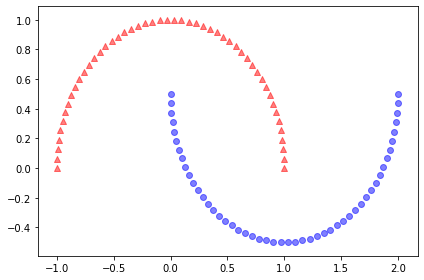

In [58]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, random_state=123)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
plt.show()

### 2. Projecting the dataset onto the principal components via standard PCA
- A linear classifer clearly cannot separate this dataset even after the transformation via PCA

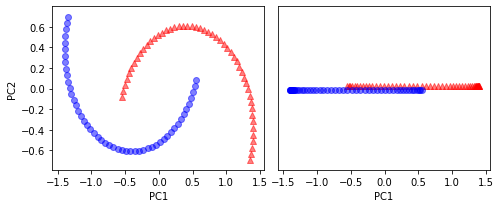

In [60]:
from sklearn.decomposition import PCA

scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((50, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((50, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
plt.show()

### 3. Projecting with KPCA (kernel PCA) instead
- Gamma parameter is a hyperparameter, so it has to be tuned and there is no universal value for it that works well for all problems and datasets

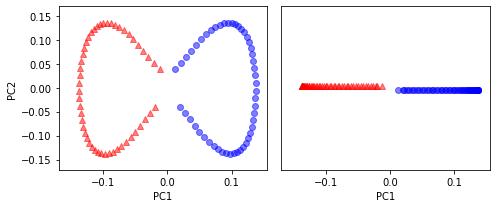

In [61]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], 
            color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
            color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y==0, 0], np.zeros((50, 1))+0.02, 
            color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50, 1))-0.02,
            color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
plt.show()

## 2.2 Example 2: Separating concentric circles
### 1. Generating the dataset

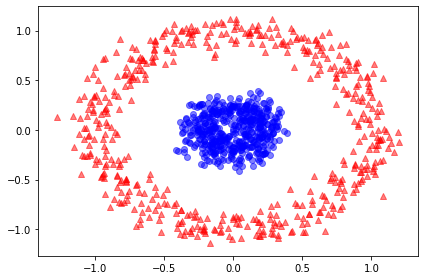

In [62]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
plt.show()

### 2. Projecting the dataset onto the principal components via standard PCA

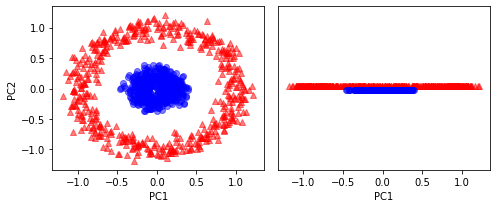

In [63]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
plt.show()

### 3. Projecting with KPCA (kernel PCA) instead

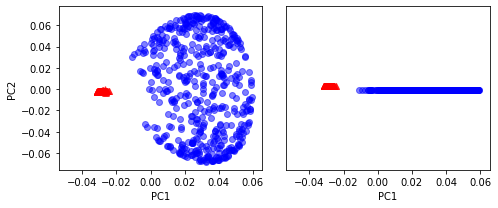

In [65]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
plt.show()

# 5. Projecting new data points
## 1. Modified implementation of RBF kernel PCA that returns the eigenvalues of the kernel matrix

In [66]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.

    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_examples, n_features]
        
    gamma: float
      Tuning parameter of the RBF kernel
        
    n_components: int
      Number of principal components to return

    Returns
    ------------
     alphas: {NumPy ndarray}, shape = [n_examples, k_features]
       Projected dataset 
     
     lambdas: list
       Eigenvalues

    """
    # Calculate pairwise squared Euclidean distances
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Convert pairwise distances into a square matrix.
    mat_sq_dists = squareform(sq_dists)

    # Compute the symmetric kernel matrix.
    K = exp(-gamma * mat_sq_dists)

    # Center the kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenpairs from the centered kernel matrix
    # scipy.linalg.eigh returns them in ascending order
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # Collect the top k eigenvectors (projected examples)
    alphas = np.column_stack([eigvecs[:, i]
                              for i in range(n_components)])

    # Collect the corresponding eigenvalues
    lambdas = [eigvals[i] for i in range(n_components)]

    return alphas, lambdas

## 2. Create a new half-moon dataset and project it onto a one-dimensional subspace

In [67]:
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = rbf_kernel_pca(X, gamma=15, n_components=1)

## 3. Test the code for projecting new examples
### 1. Take an existing data point and assume it is a new one

In [68]:
x_new = X[25]
x_new

array([1.8713, 0.0093])

### 2. Check original projection value

In [74]:
x_proj = alphas[25] # original projection
x_proj

array([0.0788])

### 3. Check if we can reproduce the original projection

In [72]:
def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum((x_new - row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)

# projection of the "new" datapoint
x_reproj = project_x(x_new, X, gamma=15, alphas=alphas, lambdas=lambdas)
x_reproj 

array([0.0788])

## 4. Visualize the projection on the first principal component

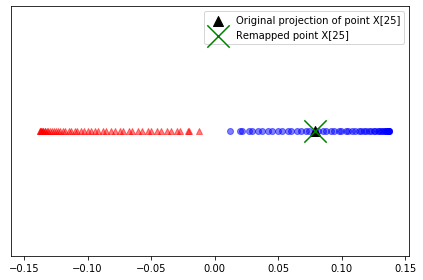

In [75]:
plt.scatter(alphas[y == 0, 0], np.zeros((50)),
            color='red', marker='^', alpha=0.5)
plt.scatter(alphas[y == 1, 0], np.zeros((50)),
            color='blue', marker='o', alpha=0.5)
plt.scatter(x_proj, 0, color='black',
            label='Original projection of point X[25]', marker='^', s=100)
plt.scatter(x_reproj, 0, color='green',
            label='Remapped point X[25]', marker='x', s=500)
plt.yticks([], [])
plt.legend(scatterpoints=1)

plt.tight_layout()
plt.show()

# 6. Kernel principal component analysis in scikit-learn
- We can specify which kernel we want to use with KernelPCA object from scikit-learn

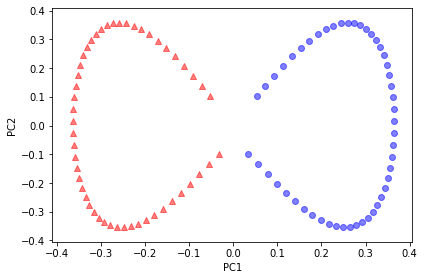

In [76]:
from sklearn.decomposition import KernelPCA

X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

plt.scatter(X_skernpca[y == 0, 0], X_skernpca[y == 0, 1],
            color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y == 1, 0], X_skernpca[y == 1, 1],
            color='blue', marker='o', alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()